[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/okada-tak/deep-learning-from-scratch/blob/master/notebooks/ch08.ipynb)
[![Open in SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/okada-tak/deep-learning-from-scratch/blob/master/notebooks/ch08.ipynb)  
# ■ch08/xxxx.py以外は追記（岡田）
# 8章 ディープラーニング のまとめ
- 多くの問題では、ネットワークを深くすることで、性能の向上が期待できる。  
- ILSVRCと呼ばれる画像認識のコンペティションの最近の動向は、ディープラーニングによる手法が上位を独占し、使われるネットワークもディープ化している。  
- 有名なネットワークには、VGG、GoogLeNet、ResNetがある。  
- GPUや分散学習、ビット精度の削減などによってディープラーニングの高速化を実現できる。  
- ディープラーニング（ニューラルネットワーク）は、物体認識だけではなく、物体検出やセグメンテーションに利用できる。  
- ディープラーニングを用いたアプリケーションとして、画像のキャプション生成、画像の生成、強化学習などがある。最近では、自動運転へのディープラーニングの利用も期待されている。

※注：本書に書かれている内容は2016年当時のものであることに注意。現時点ですでに6年たっているので、2016年当時はこうだったと思って読むのがよいと思う。

# 8.1 ネットワークをより深く
## 8.1.1 よりディープなネットワークへ


# ■追記（岡田）Colaboratory用
Google Colaboratoryの場合、Google Driveに  
dl-from-scratch/ch08  
というフォルダを用意し、そこにこのjupyter notebookを配置。  
(dl-from-scratchの部分は任意。)  
また、datasetフォルダとcommonフォルダを
dl-from-scratch/dataset  
dl-from-scratch/common
にコピーしておく。  

以下のセルでGoogle Driveをマウント。許可を求められるので許可する。

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ■追記（岡田）Colaboratory用
chdirする。

In [2]:
import sys,os
os.chdir('/content/drive/My Drive/dl-from-scratch/ch08')
os.getcwd()

'/content/drive/My Drive/dl-from-scratch/ch08'

# ch08/deep_convnet.py

In [3]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *


class DeepConvNet:
    """認識率99%以上の高精度なConvNet

    ネットワーク構成は下記の通り
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        affine - relu - dropout - affine - dropout - softmax
    """
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param_1 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_2 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_3 = {'filter_num':32, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_4 = {'filter_num':32, 'filter_size':3, 'pad':2, 'stride':1},
                 conv_param_5 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_6 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 hidden_size=50, output_size=10):
        # 重みの初期化===========
        # 各層のニューロンひとつあたりが、前層のニューロンといくつのつながりがあるか（TODO:自動で計算する）
        pre_node_nums = np.array([1*3*3, 16*3*3, 16*3*3, 32*3*3, 32*3*3, 64*3*3, 64*4*4, hidden_size])
        weight_init_scales = np.sqrt(2.0 / pre_node_nums)  # ReLUを使う場合に推奨される初期値
        
        self.params = {}
        pre_channel_num = input_dim[0]
        for idx, conv_param in enumerate([conv_param_1, conv_param_2, conv_param_3, conv_param_4, conv_param_5, conv_param_6]):
            self.params['W' + str(idx+1)] = weight_init_scales[idx] * np.random.randn(conv_param['filter_num'], pre_channel_num, conv_param['filter_size'], conv_param['filter_size'])
            self.params['b' + str(idx+1)] = np.zeros(conv_param['filter_num'])
            pre_channel_num = conv_param['filter_num']
        self.params['W7'] = weight_init_scales[6] * np.random.randn(64*4*4, hidden_size)
        self.params['b7'] = np.zeros(hidden_size)
        self.params['W8'] = weight_init_scales[7] * np.random.randn(hidden_size, output_size)
        self.params['b8'] = np.zeros(output_size)

        # レイヤの生成===========
        self.layers = []
        self.layers.append(Convolution(self.params['W1'], self.params['b1'], 
                           conv_param_1['stride'], conv_param_1['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W2'], self.params['b2'], 
                           conv_param_2['stride'], conv_param_2['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Convolution(self.params['W3'], self.params['b3'], 
                           conv_param_3['stride'], conv_param_3['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W4'], self.params['b4'],
                           conv_param_4['stride'], conv_param_4['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Convolution(self.params['W5'], self.params['b5'],
                           conv_param_5['stride'], conv_param_5['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W6'], self.params['b6'],
                           conv_param_6['stride'], conv_param_6['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Affine(self.params['W7'], self.params['b7']))
        self.layers.append(Relu())
        self.layers.append(Dropout(0.5))
        self.layers.append(Affine(self.params['W8'], self.params['b8']))
        self.layers.append(Dropout(0.5))
        
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x, train_flg=False):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x, train_flg=True)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx, train_flg=False)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        tmp_layers = self.layers.copy()
        tmp_layers.reverse()
        for layer in tmp_layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            grads['W' + str(i+1)] = self.layers[layer_idx].dW
            grads['b' + str(i+1)] = self.layers[layer_idx].db

        return grads

    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            self.layers[layer_idx].W = self.params['W' + str(i+1)]
            self.layers[layer_idx].b = self.params['b' + str(i+1)]


# ch08/awesome_net.py

In [ ]:
# Create your awesome net!!

# ch08/train_deepnet.py

↓はものすごい時間がかかる。（約7.5時間）

In [4]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

network = DeepConvNet()  
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=20, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr':0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
network.save_params("../ch08/deep_convnet_params.pkl")
print("Saved Network Parameters!")


ストリーミング出力は最後の 5000 行に切り捨てられました。
train loss:0.7853441934526242
train loss:0.8745073979900053
train loss:0.8317410801948563
train loss:0.7612261673751177
train loss:0.7697415554228173
train loss:0.9766088875199266
train loss:0.8223825773487793
train loss:0.8468997975519315
train loss:0.9575722353637801
train loss:0.9355733399537347
train loss:0.8484592636917383
train loss:1.2307749485061616
train loss:1.03637934951269
train loss:0.8660050697135173
train loss:0.7615253959456814
train loss:0.875109958747451
train loss:0.8203418673253323
train loss:0.8780857608433188
train loss:1.022246333694255
train loss:0.9874290476975703
train loss:0.810389761142937
train loss:0.9296156316446824
train loss:0.8848709876439041
train loss:0.9590522063236954
train loss:0.9159089077619924
train loss:0.8736073511914328
train loss:0.8972268052640703
train loss:0.8219233725772473
train loss:0.8992317638902718
train loss:1.003422914644461
train loss:0.7369333884042052
train loss:0.7867894506113865
train loss:0.9

# ch08/misclassified_mnist.py

calculating test accuracy ... 
test accuracy:0.9933
======= misclassified result =======
{view index: (label, inference), ...}
{1: (5, 8), 2: (2, 7), 3: (9, 4), 4: (2, 7), 5: (3, 5), 6: (8, 2), 7: (6, 4), 8: (2, 7), 9: (3, 5), 10: (6, 0), 11: (9, 4), 12: (7, 1), 13: (5, 7), 14: (2, 3), 15: (5, 2), 16: (2, 7), 17: (8, 2), 18: (9, 4), 19: (5, 3), 20: (5, 8)}


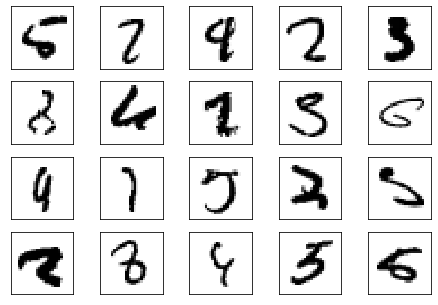

In [5]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist


(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

network = DeepConvNet()
network.load_params("../ch08/deep_convnet_params.pkl")

print("calculating test accuracy ... ")
#sampled = 1000
#x_test = x_test[:sampled]
#t_test = t_test[:sampled]

classified_ids = []

acc = 0.0
batch_size = 100

for i in range(int(x_test.shape[0] / batch_size)):
    tx = x_test[i*batch_size:(i+1)*batch_size]
    tt = t_test[i*batch_size:(i+1)*batch_size]
    y = network.predict(tx, train_flg=False)
    y = np.argmax(y, axis=1)
    classified_ids.append(y)
    acc += np.sum(y == tt)
    
acc = acc / x_test.shape[0]
print("test accuracy:" + str(acc))

classified_ids = np.array(classified_ids)
classified_ids = classified_ids.flatten()
 
max_view = 20
current_view = 1

fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.2, wspace=0.2)

mis_pairs = {}
for i, val in enumerate(classified_ids == t_test):
    if not val:
        ax = fig.add_subplot(4, 5, current_view, xticks=[], yticks=[])
        ax.imshow(x_test[i].reshape(28, 28), cmap=plt.cm.gray_r, interpolation='nearest')
        mis_pairs[current_view] = (t_test[i], classified_ids[i])
            
        current_view += 1
        if current_view > max_view:
            break

print("======= misclassified result =======")
print("{view index: (label, inference), ...}")
print(mis_pairs)

plt.show()


## 8.1.2 さらに認識精度を高めるには
- アンサンブル学習  
- 学習係数の減衰（learning rate decay）  
- **Data Augmentation**（データ拡張）

## 8.1.3 層を深くすることのモチベーション
- パラメータの数を少なくできること  
受容野を広くカバーできる  
- 活性化関数の数が増え、非線形性がさらに強まって表現力が向上する
- 学習の効率性  


# 8.2 ディープラーニングの小歴史
## 8.2.1 ImageNet
## 8.2.2 VGG
- VGG16やVGG19  

## 8.2.3 GoogLeNet
- インセプション構造（横方向に幅がある）  

## 8.2.4 ResNet
- スキップ構造  


# 8.3 ディープラーニングの高速化
## 8.3.1 取り組むべき問題
- 畳み込み層の演算の高速化が課題  
→ 積和演算

## 8.3.2 GPUによる高速化

## 8.3.3 分散学習

## 8.3.4 演算精度のビット削減


# ch08/half_float_network.py

In [6]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist


(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

network = DeepConvNet()
network.load_params("../ch08/deep_convnet_params.pkl")

sampled = 10000 # 高速化のため
x_test = x_test[:sampled]
t_test = t_test[:sampled]

print("caluculate accuracy (float64) ... ")
print(network.accuracy(x_test, t_test))

# float16に型変換
x_test = x_test.astype(np.float16)
for param in network.params.values():
    param[...] = param.astype(np.float16)

print("caluculate accuracy (float16) ... ")
print(network.accuracy(x_test, t_test))


caluculate accuracy (float64) ... 
0.9933
caluculate accuracy (float16) ... 
0.9933


# 8.4 ディープラーニングの実用例
## 8.4.1 物体検出
- 物体の位置とクラス分類  
- R-CNN, Faster R-CNN  

## 8.4.2 セグメンテーション
- FCN(Fully Convolutional Network)  

## 8.4.3 画像キャプション生成
- NIC(Newral Image Caption)  
CNNとRNNから構成  

# 8.5 ディープラーニングの未来
## 8.5.1 画像スタイル変換
## 8.5.2 画像生成
- DCGAN

## 8.5.3 自動運転
- SegNet

## 8.5.4 Deep Q-Network （強化学習）


## 8.6 まとめ